In [1]:
import glob
import pandas as pd
import datetime

import abstract_reader


abstractlist = glob.glob("abstracts/*")

xml_elements = ['datecreated', 'title', 'articletitle', 'abstracttext', 'language',  'country', 'publicationstatus']

In [2]:
df = abstract_reader.create_df(abstractlist, xml_elements)

In [3]:
df.shape

(2653, 7)

In [4]:
df[:5]

,datecreated,title,articletitle,abstracttext,language,country,publicationstatus
0,2001-03-06,diabetes care,pioglitazone hydrochloride monotherapy improve...,evaluate efficacy safety four doses pioglitazo...,eng,united states,ppublish
1,1996-05-28,archives of general psychiatry,sixmonth followup naltrexone psychotherapy alc...,goal study examine persistence naltrexones eff...,eng,united states,ppublish
2,2003-10-27,diabetes care,treattotarget trial randomized addition glargi...,compare abilities associated hypoglycemia risk...,eng,united states,ppublish
3,2001-05-04,clinical pediatrics,followup throat cultures necessary rapid antig...,frequency obtaining falsenegative group strept...,eng,united states,ppublish
4,2006-11-08,acta obstetricia et gynecologica scandinavica,prevention postpartum hemorrhage uterotonic ag...,determine efficacy intravenous oxytocin admini...,eng,denmark,ppublish


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Publications by counry

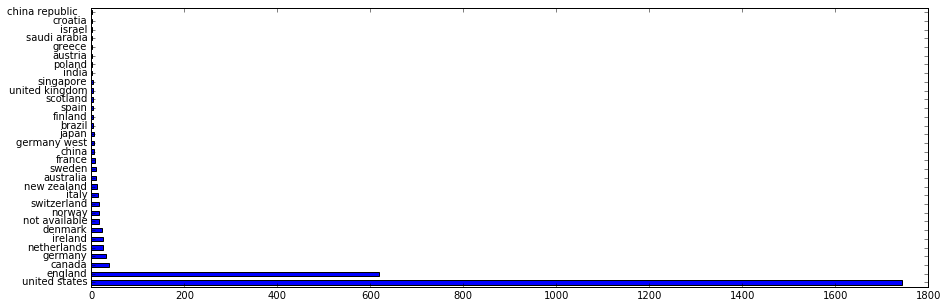

In [6]:
df['country'].value_counts().plot(kind='barh', figsize=(15, 5))

# Publication by language

In [7]:
df['language'].value_counts()

eng    2645
spa       3
dut       2
chi       1
fre       1
dan       1
Name: language, dtype: int64

# Publication by publication status

In [8]:
df['publicationstatus'].value_counts()

ppublish    2592
epublish      61
Name: publicationstatus, dtype: int64

# Publication by year of publication

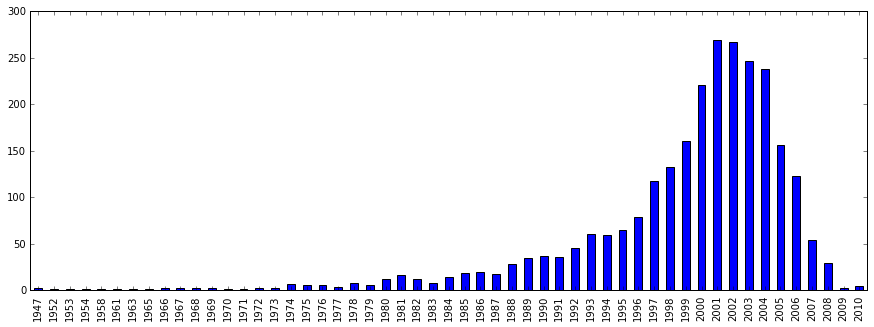

In [9]:
dates = pd.to_datetime(df.datecreated[df.datecreated != 'not available'])
dates.dt.year.value_counts(sort=False).sort_index().plot(kind='bar', figsize=(15, 5))

# Publication by number of words

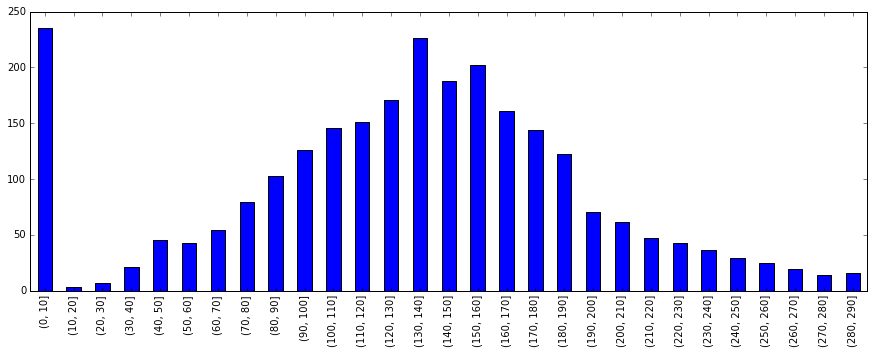

In [10]:
splitted_text = df.abstracttext.map(lambda x: len(x.split(' ')))
pd.value_counts(pd.cut(splitted_text, bins = range(0, 300, 10))).sort_index().plot(kind='bar', figsize=(15, 5))

# Top 20 used words in English publications

In [11]:
from collections import Counter
import operator

listtext = [i.split(' ') for i in df.abstracttext[df.language == 'eng'].tolist()]
listtext = [item for sublist in listtext for item in sublist]

count_words = Counter(listtext)

In [12]:
count_words_sorted = sorted(count_words.iteritems(), key=operator.itemgetter(1), reverse=True)
for _ in range(25):
    print '{1:<7} {0}'.format(count_words_sorted[_][0], count_words_sorted[_][1])

5775    patients
3304    treatment
2448    group
2397    p
2079    study
2040    risk
1771    women
1713    trials
1619    studies
1515    placebo
1448    years
1436    ci
1379    therapy
1364    compared
1332    clinical
1216    data
1198    disease
1159    significant
1150    children
1054    two
1035    months
1002    age
991     mean
991     use
978     effects
